In [1]:
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from seaborn import scatterplot
import seaborn as sns
import numpy as np
import requests
import matplotlib.pyplot as plt

%matplotlib inline

#### Set file paths:

In [2]:
data_dir = 'data'
or_dir = '../data'
twin_dir = 'data/twin_comparison'
if not os.path.isdir(twin_dir):
    os.mkdir(twin_dir)
picrust_dir = 'data/picrust_milk'
if not os.path.isdir(picrust_dir):
    os.mkdir(picrust_dir)

In [3]:
metadata = pd.read_csv(f'{or_dir}/metadata.tsv', sep='\t')

### Run Picrust2 to simulate metagenome:

In [8]:
def fetch_ipath(ids: list, img_output_path: str, verbose: bool = False):
    """Fetches a enriched pathways map from iPATH3 for given IDs."""
    url = 'https://pathways.embl.de/mapping.cgi'
    
    # remove colon from EC names
    if ':' in ids[0]:
        ids = [x.replace(':', '') for x in ids]
    
    if verbose:
        print(f'Fetching iPATH3 diagram for ids: {ids}')
    params = {
        'default_opacity': 0.6,
        'export_type': 'svg',
        'selection': '\n'.join(ids)
    }   
    response = requests.get(url=url, params=params)
    
    with open(img_output_path, 'wb') as img:
        img.write(response.content)

In [9]:
# path to the picrust2 conda environment - do not change!
picrust_env = '/opt/conda/envs/picrust2/bin'

In [13]:
%%script env picrust_env="$picrust_env" data_dir="$data_dir" picrust_dir="$picrust_dir" bash

# append the env location to PATH so that qiime
# can find all required executables
export PATH=$picrust_env:$PATH

$picrust_env/qiime picrust2 full-pipeline \
    --i-seq $data_dir/PJNB_dada2_rep_set.qza \
    --i-table $data_dir/PJNB_dada2_table_.qza \
    --output-dir $picrust_dir/picrust2_results \
    --p-placement-tool sepp \
    --p-threads 2 \
    --p-hsp-method pic \
    --p-max-nsti 2

Saved FeatureTable[Frequency] to: data/picrust_milk/picrust2_results/ko_metagenome.qza
Saved FeatureTable[Frequency] to: data/picrust_milk/picrust2_results/ec_metagenome.qza
Saved FeatureTable[Frequency] to: data/picrust_milk/picrust2_results/pathway_abundance.qza


In [4]:
! qiime metadata tabulate \
    --m-input-file $or_dir/metadata.tsv \
    --o-visualization $picrust_dir/metadata.qzv

Saved Visualization to: data/picrust_milk/metadata.qzv


### Filter Picrust Outputs:

In [4]:
! qiime feature-table filter-samples \
    --i-table $picrust_dir/picrust2_results/ko_metagenome.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --p-where "[diet_milk]='fd' or [diet_milk]='bd'" \
    --o-filtered-table $data_dir/picrust2_results/ko_metagenome_milk.qza

! qiime feature-table filter-samples \
    --i-table $picrust_dir/picrust2_results/ec_metagenome.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --p-where "[diet_milk]='fd' or [diet_milk]='bd'" \
    --o-filtered-table $picrust_dir/picrust2_results/ec_metagenome_milk.qza

! qiime feature-table filter-samples \
    --i-table $picrust_dir/picrust2_results/pathway_abundance.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --p-where "[diet_milk]='fd' or [diet_milk]='bd'" \
    --o-filtered-table $picrust_dir/picrust2_results/pjnb-path-abund-milk.qza

Usage: qiime feature-table filter-samples [OPTIONS]

  Filter samples from table based on frequency and/or metadata. Any features
  with a frequency of zero after sample filtering will also be removed. See
  the filtering tutorial on https://docs.qiime2.org for additional details.

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency¹ | RelativeFrequency² |
    PresenceAbsence³ | Composition⁴]
                       The feature table from which samples should be
                       filtered.                                    [required]
Parameters:
  --p-min-frequency INTEGER
                       The minimum total frequency that a sample must have to
                       be retained.                               [default: 0]
  --p-max-frequency INTEGER
                       The maximum total frequency that a sample can have to
                       be retained. If no value is provided this will default
                       to infinity (i.e., no maximum frequency filter will 

### Find most abundant KOs, ECs and Pathways:

In [ ]:
ko = q2.Artifact.load(f'{picrust_dir}/picrust2_results/ko_metagenome_milk.qza').view(pd.DataFrame)
ec = q2.Artifact.load(f'{picrust_dir}/picrust2_results/ec_metagenome_milk.qza').view(pd.DataFrame)
pa = q2.Artifact.load(f'{picrust_dir}/picrust2_results/pjnb-path-abund-milk.qza').view(pd.DataFrame)

In [ ]:
ko_meta = ko.merge(metadata[['diet_milk']], left_index=True, right_index=True)
ec_meta = ec.merge(metadata[['diet_milk']], left_index=True, right_index=True)
pa_meta = pa.merge(metadata[['diet_milk']], left_index=True, right_index=True)

In [ ]:
ko_meta_avg = ko_meta.groupby('diet_milk').mean()
ec_meta_avg = ec_meta.groupby('diet_milk').mean()
pa_meta_avg = pa_meta.groupby('diet_milk').mean()

In [ ]:
ko_meta_avg.head()

In [ ]:
# find top x% of the most abundant KOs, ECs and pathways in each sample type

def find_most_abundant(df: pd.DataFrame, frac):
    if 0 < frac < 1:
        frac = int(frac * len(df.columns))
    print(f'Saving {frac} most abundant features...')
    most_abundant = {
        smp: df.loc[smp, :].sort_values(ascending=False)[:frac]
        for smp in df.index
    }
    return most_abundant

ko_most_abundant = find_most_abundant(ko_meta_avg, 0.01)
ec_most_abundant = find_most_abundant(ec_meta_avg, 0.03)
pa_most_abundant = find_most_abundant(pa_meta_avg, 5)

In [ ]:
print(f'10 most abundant KOs in the breast milk group are: {ko_most_abundant["bd"].index[:10].tolist()}\n'
      f'10 most abundant KOs in the formula group are: {ko_most_abundant["fd"].index[:10].tolist()}\n')

In [ ]:
print(f'10 most abundant ECs in the breast milk group are: {ec_most_abundant["bd"].index[:10].tolist()}\n'
      f'10 most abundant ECs in the formula group are: {ec_most_abundant["fd"].index[:10].tolist()}\n')

In [ ]:
print(f'10 most abundant pathways in the breast milk group are: {pa_most_abundant["bd"].index[:10].tolist()}\n'
      f'10 most abundant pathways in the formula group are: {pa_most_abundant["fd"].index[:10].tolist()}\n')

In [15]:
! qiime composition add-pseudocount \
    --i-table $picrust_dir/picrust2_results/pjnb-path-abund-milk.qza \
    --o-composition-table $picrust_dir/picrust2_results/pjnb-path-abund-milk-pseudo.qza

Saved FeatureTable[Composition] to: data/picrust_milk/picrust2_results/pjnb-path-abund-milk-pseudo.qza


In [16]:
! qiime composition ancom \
    --i-table $picrust_dir/picrust2_results/pjnb-path-abund-milk-pseudo.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --m-metadata-column diet_milk \
    --p-transform-function log \
    --o-visualization $picrust_dir/picrust2_results/pa_ancom_milk.qzv

Saved Visualization to: data/picrust_milk/picrust2_results/pa_ancom_milk.qzv


In [17]:
Visualization.load(f'{picrust_dir}/picrust2_results/pa_ancom_milk.qzv')

<visualization: Visualization uuid: 53d0ef71-2c56-4552-bee4-e767a9789d75>

In [20]:
! qiime tools extract \
    --input-path $picrust_dir/picrust2_results/pa_ancom_milk.qzv \
    --output-path $picrust_dir/pa_ancom_milk

Extracted data/picrust_milk/picrust2_results/pa_ancom_milk.qzv to directory data/picrust_milk/pa_ancom_milk/53d0ef71-2c56-4552-bee4-e767a9789d75


In [22]:
ancomData = pd.read_csv(f'{picrust_dir}/pa_ancom_milk/53d0ef71-2c56-4552-bee4-e767a9789d75/data/data.tsv', sep='\t')
ancomSignificance = pd.read_csv(f'{picrust_dir}/pa_ancom_milk/53d0ef71-2c56-4552-bee4-e767a9789d75/data/ancom.tsv', sep='\t')
ancomSignificance.rename(columns = {'Unnamed: 0':'id'}, inplace = True)

In [23]:
ancomDataSig = ancomData.merge(ancomSignificance, how='inner')
ancomDataSig

,id,log,W,Reject null hypothesis
0,1CMET2-PWY,0.007406,167,False
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,0.793881,378,True
2,AEROBACTINSYN-PWY,0.402921,24,False
3,ALL-CHORISMATE-PWY,0.662944,373,True
4,ANAEROFRUCAT-PWY,-0.213974,306,False
...,...,...,...,...
458,TYRFUMCAT-PWY,-0.099911,30,False
459,UBISYN-PWY,0.259454,124,False
460,UDPNAGSYN-PWY,0.042079,139,False
461,VALDEG-PWY,0.023803,95,False


In [24]:
ancomDataSig.sort_values(by='log', axis=0, ascending=True)

,id,log,W,Reject null hypothesis
347,PWY-7090,-1.998128,458,True
400,PWY-7456,-1.813920,458,True
101,P221-PWY,-1.744462,454,True
78,METH-ACETATE-PWY,-1.574535,456,True
98,P163-PWY,-1.561653,456,True
...,...,...,...,...
210,PWY-5747,0.930973,405,True
428,PWY0-42,0.991533,412,True
80,METHGLYUT-PWY,0.998851,413,True
61,HCAMHPDEG-PWY,1.068510,419,True


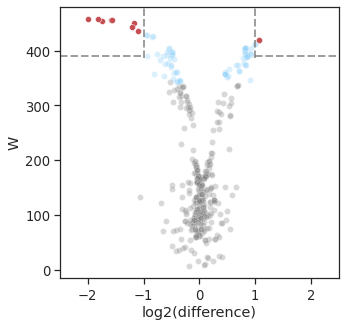

In [25]:
sns.set(rc={'figure.figsize':(5, 5)}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    ax = sns.scatterplot(
        data= ancomDataSig[(ancomDataSig['Reject null hypothesis'] == False)], 
        x='log', 
        y='W',
        color='grey',
        alpha=.3
    )
    ax = sns.scatterplot(
        data=ancomDataSig[(ancomDataSig['Reject null hypothesis'] == True) & (ancomDataSig['log']>-1)], 
        x='log', 
        y='W',
        color='lightskyblue',
        alpha=.3
    )
    ax = sns.scatterplot(
        data=ancomDataSig[(ancomDataSig['Reject null hypothesis'] == True) & (ancomDataSig['log']<-1)], 
        x='log', 
        y='W',
        color='r'
    )
    ax = sns.scatterplot(
        data=ancomDataSig[(ancomDataSig['Reject null hypothesis'] == True) & (ancomDataSig['log']>1)], 
        x='log', 
        y='W',
        color='r'
    )
ax.tick_params(axis='x', which='major', bottom=True)
ax.tick_params(axis='y', which='major', left=True)
ax.set_xlim(-2.5,2.5)
#ax.set_ylim(-5,5200)
#ax.set_yscale('log')
ax.set_xlabel('log2(difference)')
ax.axhline(y=391, xmin=0, xmax=.3, color="grey", dashes=(5, 2))
ax.axhline(y=391, xmin=.7, xmax=1, color="grey", dashes=(5, 2))
ax.axvline(x=1, ymin=0.81, ymax=1, color="grey", dashes=(5, 2))
ax.axvline(x=-1, ymin=0.81, ymax=1, color="grey", dashes=(5, 2))
ax.set_ylabel('W')
plt.savefig(f'{picrust_dir}/Volcano_picrustMilk_600dpi.png', bbox_inches='tight', dpi=600)